# K-Nearest Neighbour Clustering on a Global Scale

In [115]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import plotly.express as px
import numpy as np
import pystac_client
import xarray as xr

catalog = pystac_client.Client.open(
    #"https://storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json" # cloud API
    r"p:\1000545-054-globalbeaches\15_GlobalCoastalAtlas\coclicodata\current\catalog.json" # P drive API 
)
list(catalog.get_children())

[<CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=floodmaps>,
 <CollectionClient id=sc>,
 <CollectionClient id=cbca>,
 <CollectionClient id=cfr>,
 <CollectionClient id=cm>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=world_pop>,
 <CollectionClient id=world_gdp>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>]

In [116]:
from shapely import wkt

href_sm = catalog.get_child("shore_mon_hr").assets["data"].href
df_sm = xr.open_zarr(href_sm)[['changerate']].to_dataframe()[['transect_id', 'hotspot_id', 'changerate', 'transect_geom']].applymap(lambda x: x.decode("utf_8") if type(x) == bytes else x)
df_sm['transect_geom'] = df_sm['transect_geom'].apply(wkt.loads)
df_sm.head(2)

,transect_id,hotspot_id,changerate,transect_geom
stations,,,,
0,BOX_117_067_110,prograding_feature_polygon_2167,0.407175,"LINESTRING (-71.624166 10.990024, -71.60742 10..."
1,BOX_117_067_111,prograding_feature_polygon_2167,5.370909,"LINESTRING (-71.625 10.991483, -71.610989 11.0..."


In [117]:
href_sm = catalog.get_child("world_pop").assets["data"].href
df_pop = xr.open_zarr(href_sm)[['pop_tot']].to_dataframe()[['transect_id', 'country', 'continent', 'pop_tot']].applymap(lambda x: x.decode("utf_8") if type(x) == bytes else x)
df_pop.head(2)

,transect_id,country,continent,pop_tot
stations,,,,
0,BOX_028_183_0,Chile,South America,0.0
1,BOX_028_183_1,Chile,South America,0.0


In [118]:
from shapely.geometry import Polygon, Point, MultiLineString
from shapely.wkt import loads
import geopandas as gpd

df_merged = df_pop.merge(df_sm, on = 'transect_id', how= 'left').groupby('hotspot_id').agg({'changerate': 'mean', 'pop_tot': 'mean', 'transect_geom': list})

# create linestrings
df_merged['polygon'] = df_merged.apply(lambda x: MultiLineString(x['transect_geom']), axis= 1)
df_merged = gpd.GeoDataFrame(df_merged, geometry='polygon')

# merge MultiLineString objects and create envelope
df_merged['polygon'] = df_merged['polygon'].convex_hull

In [119]:
df_merged['changerate'].isna().any(), df_merged['pop_tot'].isna().any()

(False, False)

In [120]:
min(df_merged['changerate']), max(df_merged['changerate'])

(-2559.886064997741, 62.17529487609863)

In [121]:
min(df_merged['pop_tot']), max(df_merged['pop_tot'])

(0.0, 249910.58266666668)

In [122]:
df_merged = df_merged[df_merged['changerate'] >= -500]

In [123]:
# input features to cluster on
df_fit = df_merged[['changerate', 'pop_tot']].dropna(axis = 0)
# perform a standard scaling
scaler = MinMaxScaler()
df_scaled_fit = scaler.fit_transform(df_fit)

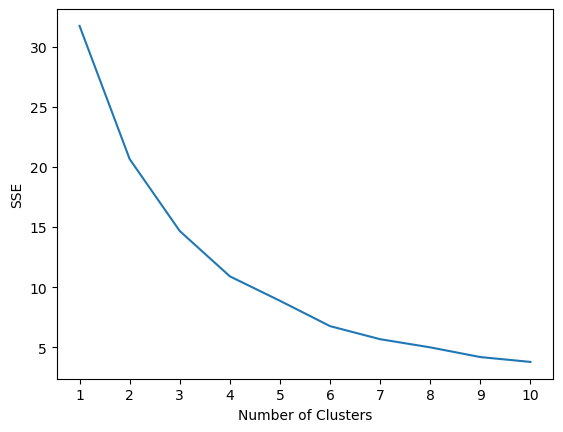

In [124]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled_fit)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [125]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters= 4, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(df_scaled_fit)

KMeans(init='random', n_clusters=4, n_init=10, random_state=1)

In [126]:
labels = [f'cluster {int(x)}' for x in kmeans.labels_]
df_merged = df_merged.assign(cluster = labels)
df_merged

,changerate,pop_tot,transect_geom,polygon,cluster
hotspot_id,,,,,
prograding_feature_polygon_1,-0.078720,0.000000,"[LINESTRING (13.746586 66.240552, 13.744609 66...","POLYGON ((13.70319 66.23720, 13.69992 66.24432...",cluster 1
prograding_feature_polygon_10,2.587726,104.331994,"[LINESTRING (11.236603 64.078695, 11.240477 64...","POLYGON ((11.24395 64.06700, 11.22636 64.06859...",cluster 3
prograding_feature_polygon_100,0.957202,2545.999469,"[LINESTRING (0.083052 49.365717, 0.070023 49.3...","POLYGON ((0.03342 49.33503, 0.02201 49.34407, ...",cluster 3
prograding_feature_polygon_1000,0.593314,0.000000,"[LINESTRING (62.159666 25.226322, 62.1606 25.2...","POLYGON ((62.16060 25.21009, 62.15967 25.22632...",cluster 3
prograding_feature_polygon_1002,13.479387,2517.489765,"[LINESTRING (63.472553 25.237158, 63.488416 25...","POLYGON ((63.47255 25.23716, 63.47020 25.24198...",cluster 2
...,...,...,...,...,...
retreating_feature_polygon_995,-4.560150,8220.132750,"[LINESTRING (102.275231 6.18663, 102.282641 6....","POLYGON ((102.27523 6.18663, 102.27114 6.18847...",cluster 1
retreating_feature_polygon_996,-7.850073,3700.805620,"[LINESTRING (102.076671 6.242656, 102.086476 6...","POLYGON ((102.07667 6.24266, 102.06162 6.25240...",cluster 1
retreating_feature_polygon_997,-1.852390,2208.452375,"[LINESTRING (101.99465 6.297944, 102.004942 6....","POLYGON ((101.99465 6.29794, 101.98729 6.30306...",cluster 1


<AxesSubplot: xlabel='changerate', ylabel='pop_tot'>

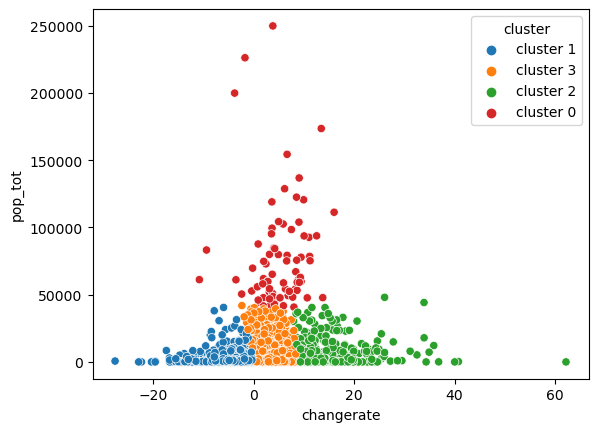

In [127]:
import seaborn as sns

sns.scatterplot(df_merged, x = 'changerate', y = 'pop_tot', hue = 'cluster')

In [244]:
df_merged_filt = df_merged[((df_merged['changerate'] <= -5) | (df_merged['changerate'] >= 5)) & (df_merged['pop_tot'] >= 10000)]
df_merged_filt['polygon'] = df_merged_filt['polygon'].buffer(0)
df_merged_filt = df_merged_filt[df_merged_filt.polygon.area != 0]
df_merged_filt.drop('transect_geom', axis = 1, inplace = True)
df_merged_filt = df_merged_filt.set_crs('EPSG:4326')

df_merged_filt['center_x'] = df_merged_filt['polygon'].centroid.x
df_merged_filt['center_y'] = df_merged_filt['polygon'].centroid.y

df_merged_filt.head(2)

c:\Users\heijd_de\Anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\heijd_de\AppData\Local\Temp\ipykernel_9384\4218278973.py:7: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\heijd_de\AppData\Local\Temp\ipykernel_9384\4218278973.py:8: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,changerate,pop_tot,polygon,cluster,center_x,center_y
hotspot_id,,,,,,
prograding_feature_polygon_1027,8.002133,40775.602500,"POLYGON ((66.93997 24.85026, 66.93661 24.86628...",cluster 0,66.949327,24.860198
prograding_feature_polygon_1028,9.935418,120593.402131,"POLYGON ((67.03490 24.78613, 66.96985 24.79452...",cluster 0,67.002985,24.808198


In [245]:
import plotly.graph_objects as go

fig = go.Figure()

fig1 = px.choropleth_mapbox(
                    df_merged_filt, 
                    geojson= df_merged_filt.polygon,
                    locations=df_merged_filt.index,
                    color = 'changerate',
                    color_continuous_scale = 'RdYlGn',
                    mapbox_style='carto-positron',
                    range_color=[-10, 10],
                    zoom = 1,
                    width = 1000,
                    height = 600)

fig2  = px.scatter_mapbox(df_merged_filt, 
                    lon = 'center_x',
                    lat = 'center_y',
                    color = 'changerate',
                    color_continuous_scale = 'RdYlGn',
                    mapbox_style='carto-positron',
                    range_color=[-10, 10],
                    zoom = 1,
                    width = 1000,
                    height = 600)

fig1.update_traces(marker_line_width=0)
fig1.add_trace(fig2.data[0])
fig1.show()